# Comparação dos valores medidos e simulados de Ks

In [51]:
import os
import json
import math
import random
import hashlib
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from utils import Infiltrometro, ALL_FUNCTIONS, nse, points_distance

from tqdm import tqdm
from xgboost import XGBRegressor
from shapely.geometry import Point
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations, product, islice
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import QuantileTransformer

In [7]:
run_ml = True
run_math = True

all_functions = {
    "WMssc": ALL_FUNCTIONS["WMssc"],
    "COSBY": ALL_FUNCTIONS["COSBY"],
    "ROssc": ALL_FUNCTIONS["ROssc"],
    "JULIA": ALL_FUNCTIONS["JULIA"],
    "Puckett": ALL_FUNCTIONS["Puckett"],
    "DanePuckett": ALL_FUNCTIONS["DanePuckett"],
    "Saxton":ALL_FUNCTIONS["Saxton"],
}

In [14]:
infil = pd.read_excel(r"D:\Mestrado\Trabalho Final\Dados\Levantamento em Campo\Compiled.xlsx", sheet_name="Infiltracao")
infil:Infiltrometro = Infiltrometro(infil)

[ True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False]


d:\Mestrado\Trabalho Final\Codigos\utils\infiltracao\infiltrometro.py:156: OptimizeWarning: Covariance of the parameters could not be estimated
  (c1, c2), covariance = curve_fit(self._equation_infiltration, t, I)


In [15]:
# K  = infil.K()  # Este valor de K é o K para -2cm de poropressão.
df_Ks:pd.DataFrame = infil.Ks() # Ks é a condutividade Hidráulica Saturada.

len(df_Ks)

Cálculos utilizando C1


84

In [16]:
alfa = df_Ks["alfa"].values
n = df_Ks["n"].values
K = df_Ks["K"].values
Ks:np.ndarray = df_Ks["Ks"].values

In [17]:
def quantile_mapping(sim, obs):
    """Aplica Quantile Mapping (QM) de simulado -> observado"""
    # Ajusta distribuições separadas
    qm_sim = QuantileTransformer(output_distribution="uniform", n_quantiles=min(100, sim.size))
    qm_obs = QuantileTransformer(output_distribution="uniform", n_quantiles=min(100, obs.size))
    
    # Treina cada um na sua série
    qm_sim.fit(sim.reshape(-1, 1))
    qm_obs.fit(obs.reshape(-1, 1))
    
    # Leva simulado para espaço uniforme
    u = qm_sim.transform(sim.reshape(-1, 1))
    
    # Reprojeta no espaço do observado
    sim_corr = qm_obs.inverse_transform(u)
    return sim_corr.flatten()

In [18]:
# Cálculo da distância entre os pontos

# Método 1
initial_point=infil.infiltrations[infil.infiltrations["Ponto"] == "P21"].index.values[0]
df_Ks["distancia_media"] = points_distance(infil.infiltrations, initial_point)

# Método 2
# points = infil.infiltrations.apply(lambda row: Point(row["Lon"], row["Lat"]), axis=1).values
# distances = np.zeros((len(points), len(points)))
# for i in range(len(points)):
#     for j in range(len(points)):
#         distances[i, j] = points[i].distance(points[j])

# # Distancia média entre pontos
# mask = ~np.eye(distances.shape[0], dtype=bool)
# sem_diag = distances[mask].reshape(distances.shape[0], -1)
# medias = sem_diag.mean(axis=1)
# df_Ks["distancia_media"] = medias

# df_Ks = df_Ks.sort_values(by="distancia_media", ascending=False)
df_Ks

,Ponto,Ks,K,Kr,θr,θs,n,alfa,Se,l,distancia_media
0,P02,0.034201,0.008819,0.257854,0.119424,0.406573,1.23,0.027,0.994923,0.5,16
1,P04,0.278450,0.009209,0.033072,0.069378,0.380130,1.89,0.075,0.987206,0.5,5
2,P06,0.005821,0.002537,0.435923,0.121254,0.478508,1.09,0.005,0.999456,0.5,18
3,P08,0.009151,0.001195,0.130601,0.107799,0.420473,1.31,0.019,0.996765,0.5,38
4,P09,0.006759,0.001743,0.257854,0.119543,0.407933,1.23,0.027,0.994923,0.5,36
...,...,...,...,...,...,...,...,...,...,...,...
79,P155,0.172957,0.008949,0.051741,0.102880,0.405278,1.56,0.036,0.994143,0.5,6
80,P156,0.904869,0.046819,0.051741,0.093184,0.414113,1.56,0.036,0.994143,0.5,2
81,P157,0.288717,0.014938,0.051741,0.080419,0.393235,1.56,0.036,0.994143,0.5,9
82,P161,0.067546,0.002234,0.033072,0.076784,0.386728,1.89,0.075,0.987206,0.5,33


In [20]:
urb = infil.infiltrations[infil.infiltrations["SoloIDE"]=="Área urbanizada"]
arg = infil.infiltrations[infil.infiltrations["SoloIDE"]=="Argissolo vermelho-amarelo distrófico"]
neo = infil.infiltrations[infil.infiltrations["SoloIDE"]=="Neossolo litólico distrófico"]

len(infil.infiltrations), len(urb), len(arg), len(neo), len(urb)+len(arg)+len(neo)

(84, 15, 27, 42, 84)

In [62]:
def _combinations(idxs_foi, size, rng):
    idx_choice_urb = rng.choice(urb.index, size=min(len(urb), size), replace=False)
    idx_choice_arg = rng.choice(arg.index, size=min(len(arg), size), replace=False)
    idx_choice_neo = rng.choice(neo.index, size=min(len(neo), size), replace=False)

    idx_choice = np.concat([idx_choice_urb, idx_choice_arg, idx_choice_neo])
    idx_choice.sort()
    data_str = json.dumps(idx_choice.tolist(), sort_keys=True)
    h = hashlib.sha256(data_str.encode()).hexdigest()

    while h in idxs_foi:
        idx_choice_urb = rng.choice(urb.index, size=min(len(urb), size), replace=False)
        idx_choice_arg = rng.choice(arg.index, size=min(len(arg), size), replace=False)
        idx_choice_neo = rng.choice(neo.index, size=min(len(neo), size), replace=False)

        idx_choice = np.concat([idx_choice_urb, idx_choice_arg, idx_choice_neo])
        idx_choice.sort()
        data_str = json.dumps(idx_choice.tolist(), sort_keys=True)
        h = hashlib.sha256(data_str.encode()).hexdigest()

    return (idx_choice, h)
    


In [71]:
# Seed para permitir reprodutibilidade dos valores pseudo-aleatórios
seed = 42

# Definir uma seed para reprodutibilidade
rng = np.random.default_rng(seed)

KSS:dict[str, dict[str, np.ndarray]] = {}

N_simulacoes = 50_000

pontos_CV = df_Ks["Ponto"].values

sand = infil.infiltrations["Sand"].values
silt = infil.infiltrations["Silt"].values
clay = infil.infiltrations["Clay"].values

y = np.log10(Ks.astype(np.float64))

n_max = max(len(urb), len(arg), len(neo))

for key, value in all_functions.items():
    KSS[key] = {}

    # Local para salvar os resultados do tipo
    path = f"simulacoes/2/{key}"
    os.makedirs(path, exist_ok=True)

    # Dados sem a correção de viés
    kss:np.ndarray = np.log10(value(sand, silt, clay))
    KSS[key][key] = kss

    # Aplicando as correções de viés
    KSS[key]["CVS"] = {}
    for i in range(0, n_max+1):
        KSS[key]["CVS"][f"CV_{i}"] = []

        # Quando for a combinação com 0 elementos, valores sem correção de viés.
        if i == 0:
            dados = {
                "N_SIM": 0,
                "KSS":kss,
                "NSE":nse(kss, y, y.mean()),
                "RMSE":root_mean_squared_error(y, kss)
            }
            KSS[key]["CVS"][f"CV_{i}"].append(dados)

        else:
            continue
            # combs_urb = list(combinations(rng.choice(urb.index, 10, replace=False), i))
            # combs_arg = list(combinations(rng.choice(arg.index, 10, replace=False), i))
            # combs_neo = list(combinations(rng.choice(neo.index, 10, replace=False), i))
            
            # todas = product(combs_urb, combs_arg, combs_neo)
            # combs = [list(u) + list(a) + list(n) for u, a, n in islice(todas, N_simulacoes)]

            comb1 = math.comb(len(urb), min(len(urb), i))
            comb2 = math.comb(len(arg), min(len(arg), i))
            comb3 = math.comb(len(neo), min(len(neo), i))
            comb = comb1*comb2*comb3

            if comb > N_simulacoes:
                comb = N_simulacoes

            
            idxs_foi = set()
            for sim in tqdm(range(1, comb+1), desc=f"Simulando: {key}-{i}", total=comb):
                idx_choice, h = _combinations(idxs_foi, i, rng)
                values = df_Ks.loc[idx_choice]

                # Dados com a correção de viés
                obs = np.log10(values["Ks"].values)
                kss_cv = quantile_mapping(kss, obs)

                # Dados a serem salvos
                dados = {
                    "N_SIM": sim,
                    "KSS":kss_cv,
                    "NSE":nse(kss_cv, y, y.mean()),
                    "RMSE":root_mean_squared_error(y, kss_cv)
                }
                KSS[key]["CVS"][f"CV_{i}"].append(dados)

        if len(KSS[key]["CVS"][f"CV_{i}"]) == 0:
            continue

        df = pd.DataFrame(KSS[key]["CVS"][f"CV_{i}"])
        
        df["NSE_MAX"]    = df["NSE"].max()
        df["NSE_MIN"]    = df["NSE"].min()
        df["NSE_MEAN"]   = df["NSE"].mean()
        df["NSE_MEDIAN"] = df["NSE"].median()
        
        df["RMSE_MAX"]    = df["RMSE"].max()
        df["RMSE_MIN"]    = df["RMSE"].min()
        df["RMSE_MEAN"]   = df["RMSE"].mean()
        df["RMSE_MEDIAN"] = df["RMSE"].median()
        
        df.pop("KSS")
        df.to_excel(f"{path}/CV_{i}.xlsx", index=False)

        KSS[key]["CVS"][f"CV_{i}"] = df

KSS.keys()

A função proposta por Saxton não funciona corretamente


dict_keys(['WMssc', 'COSBY', 'ROssc', 'JULIA', 'Puckett', 'DanePuckett', 'Saxton'])

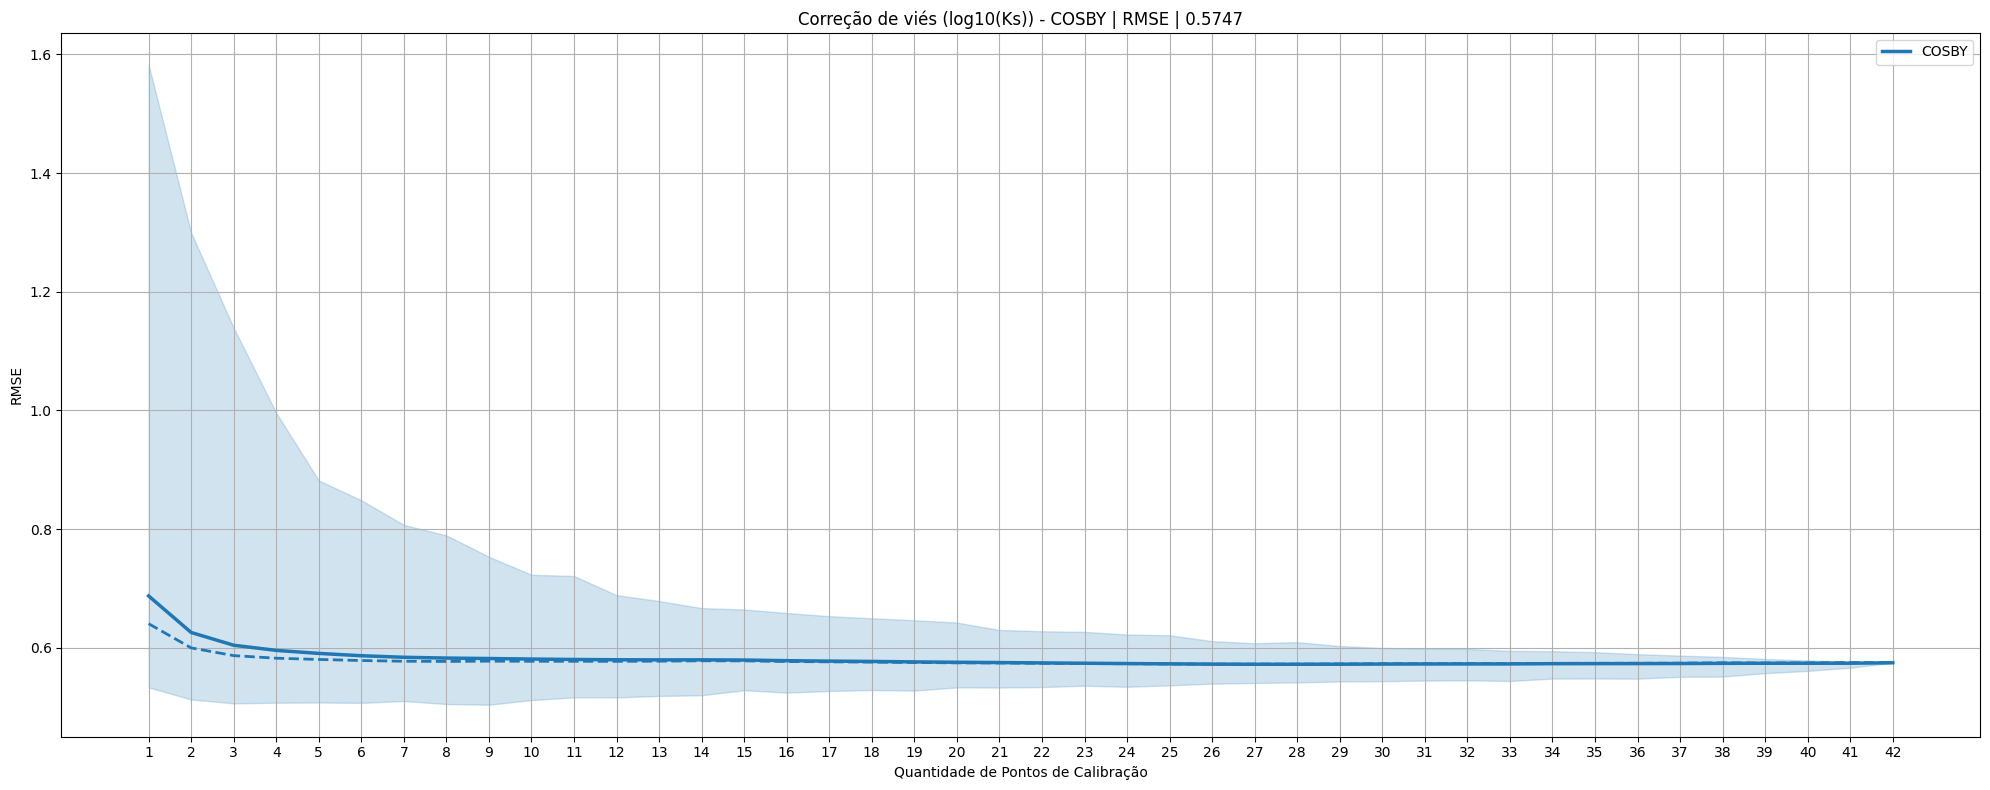

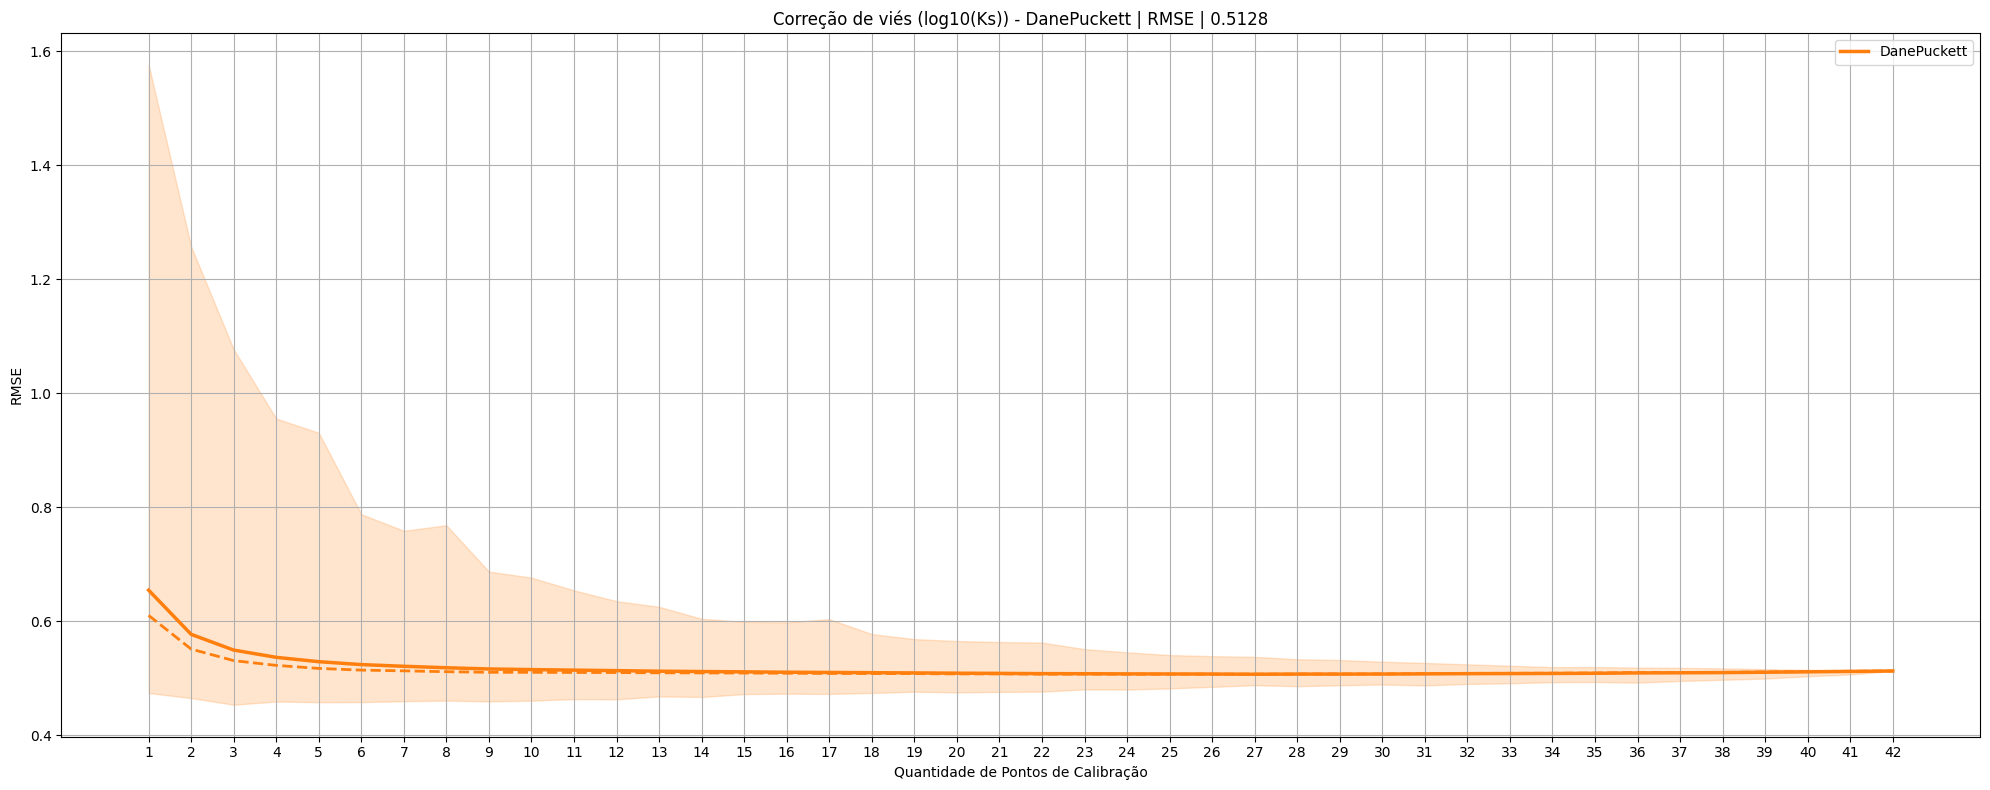

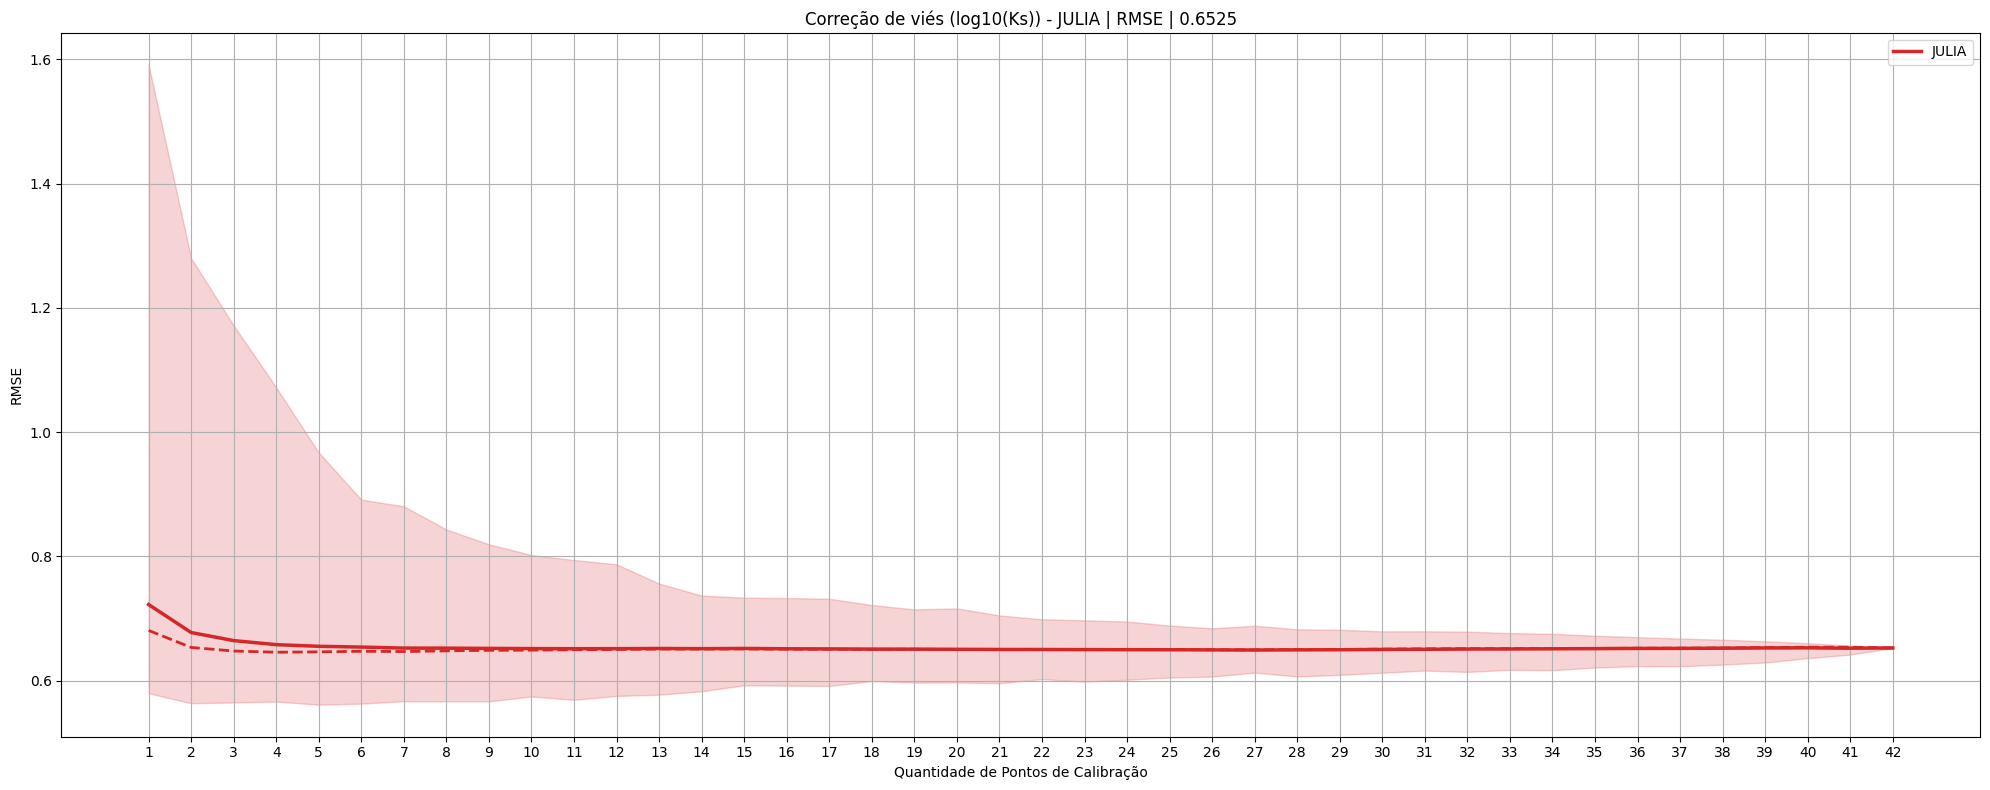

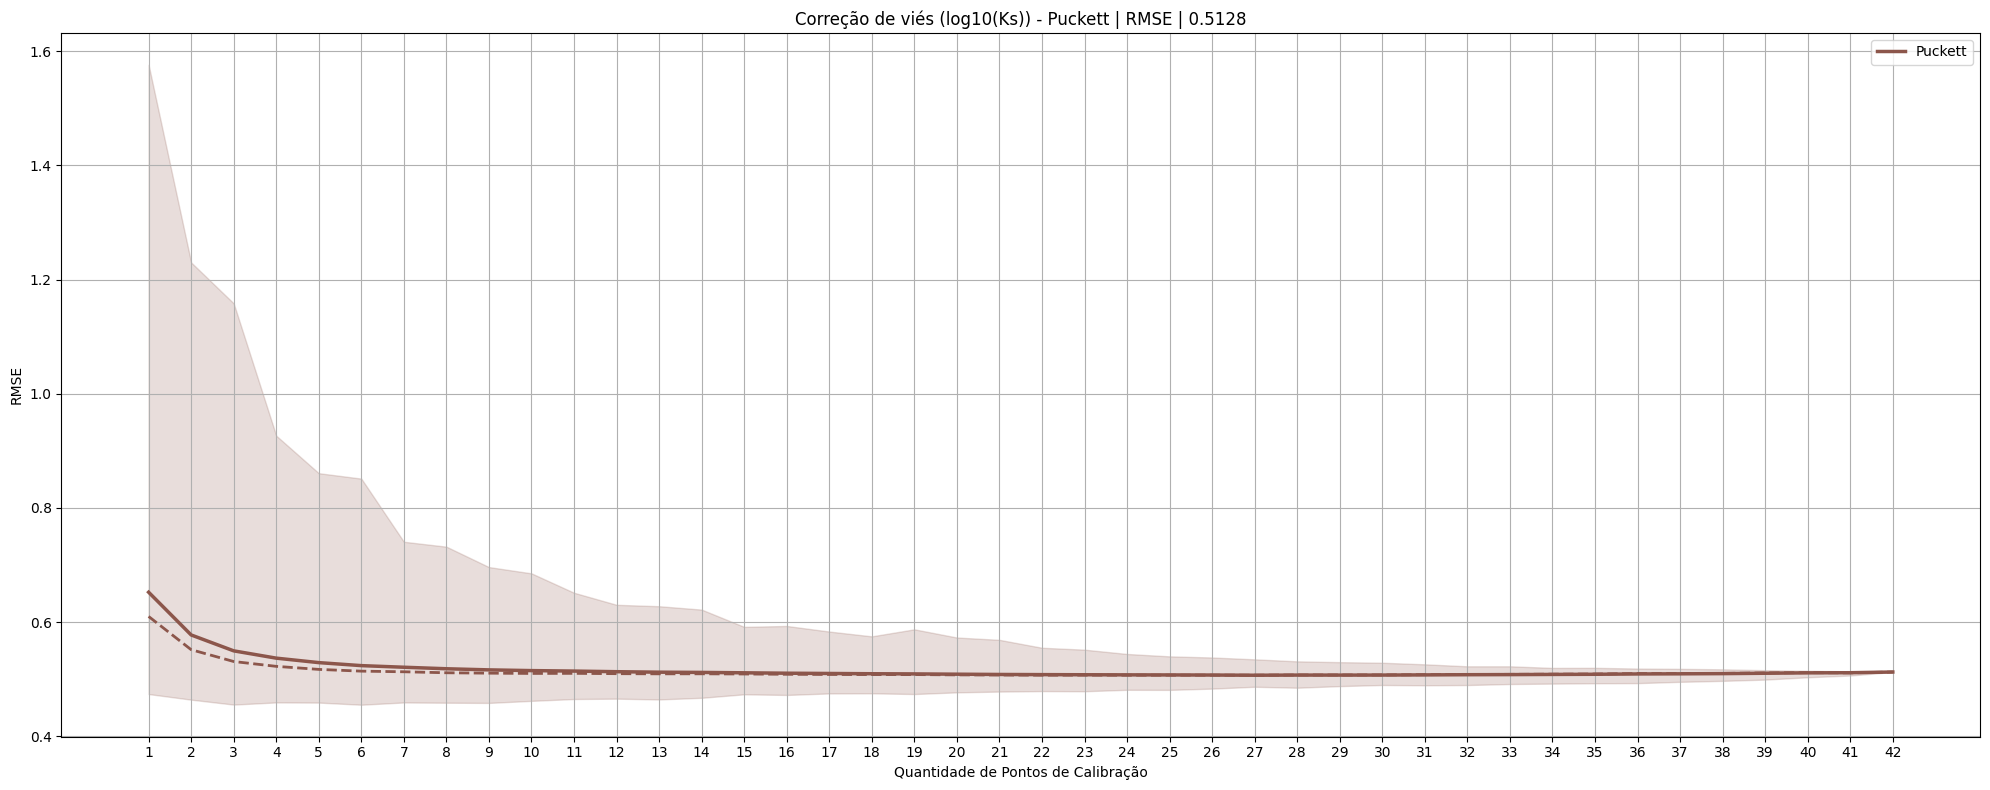

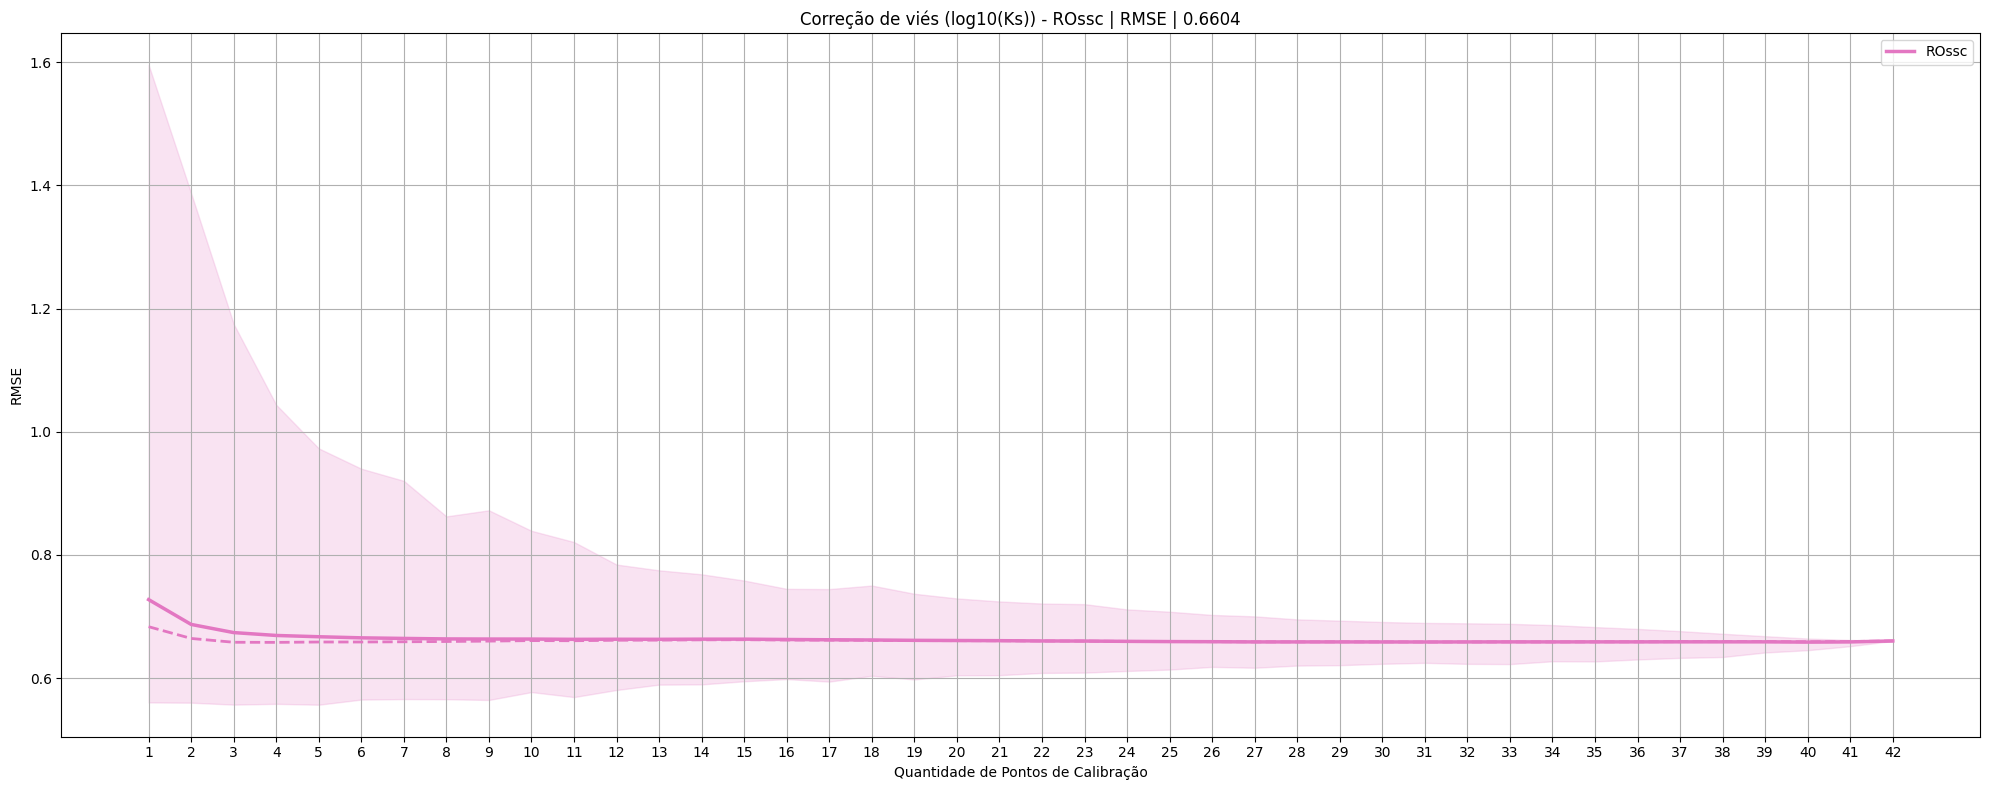

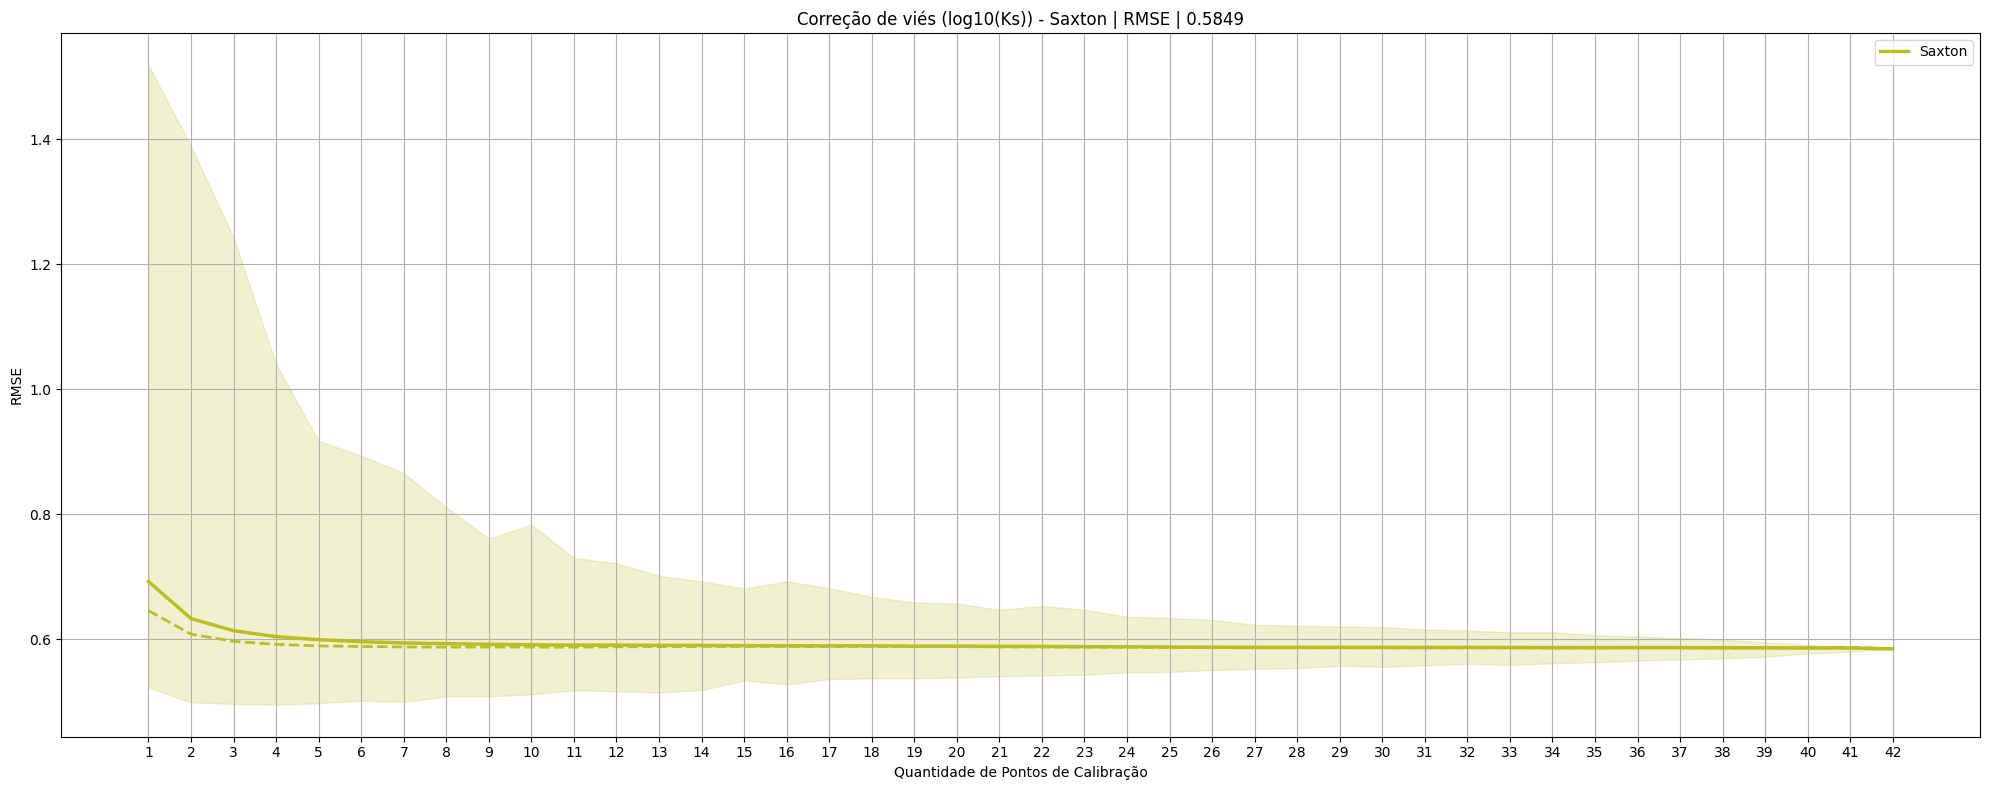

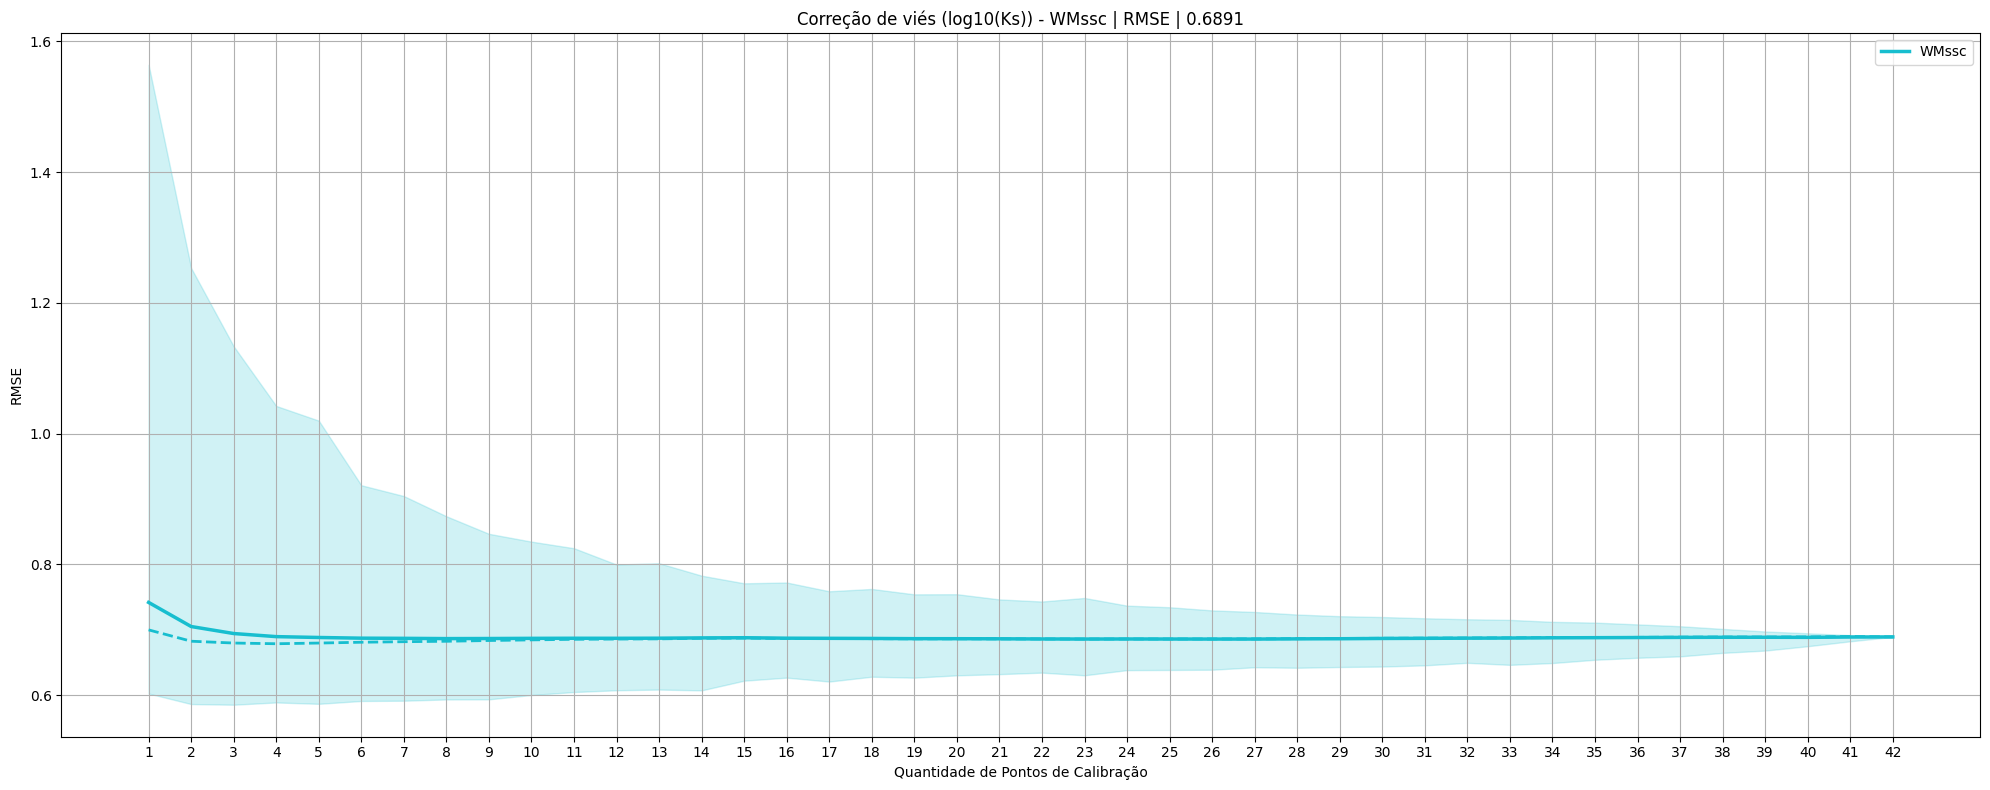

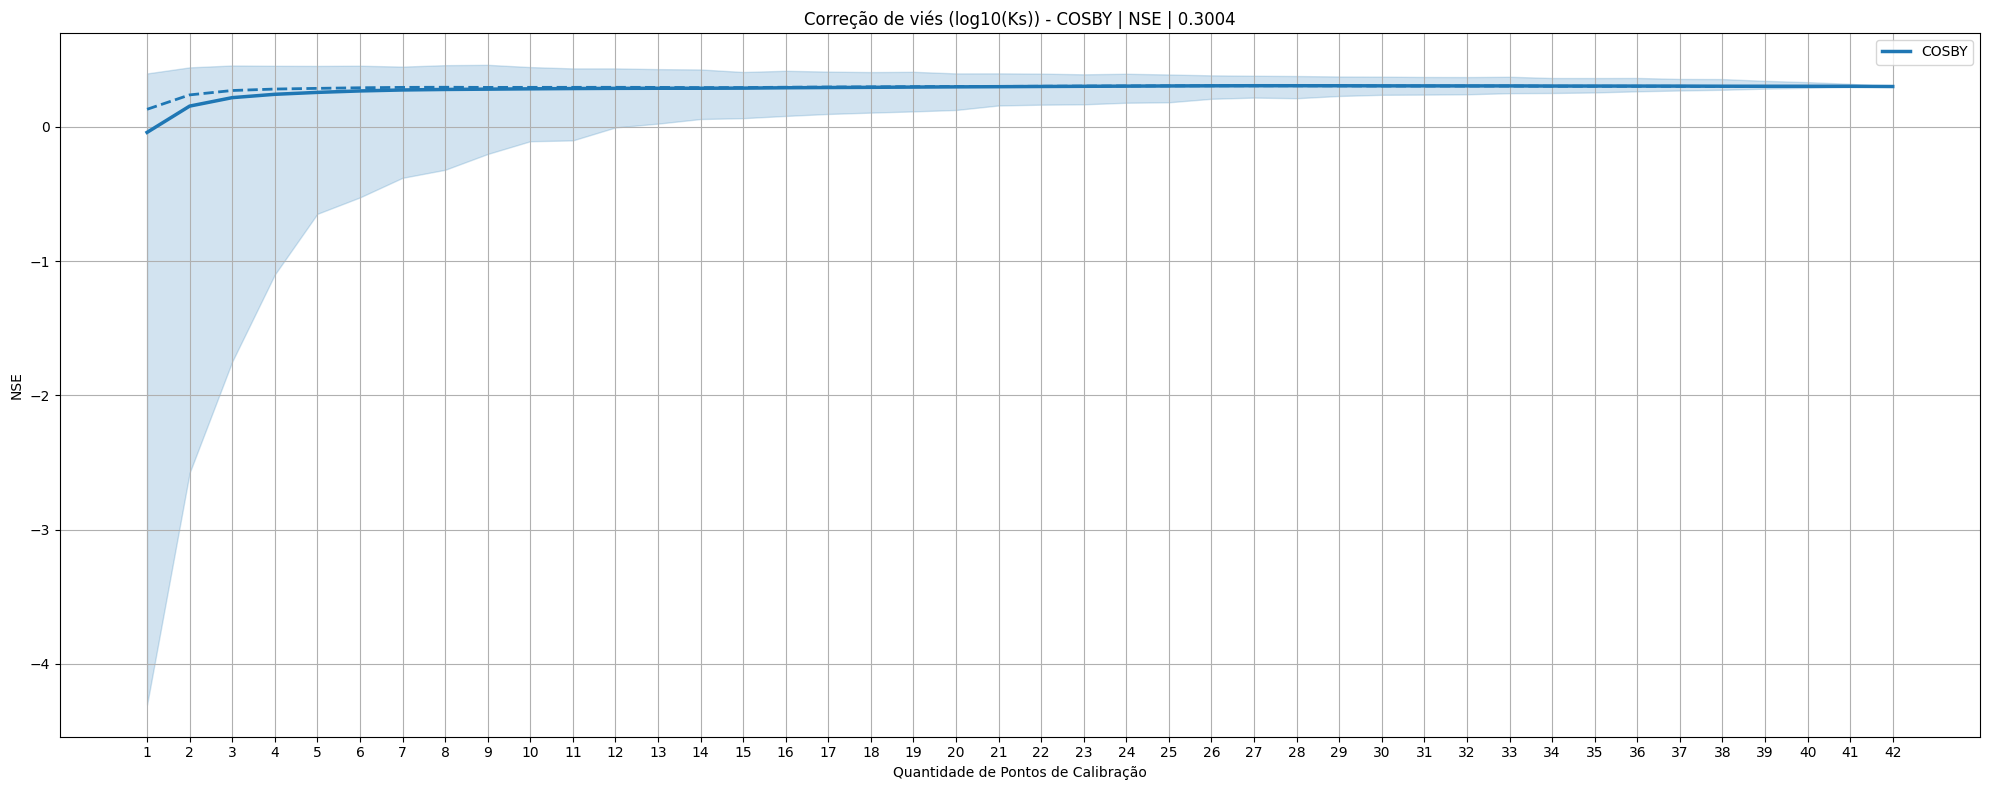

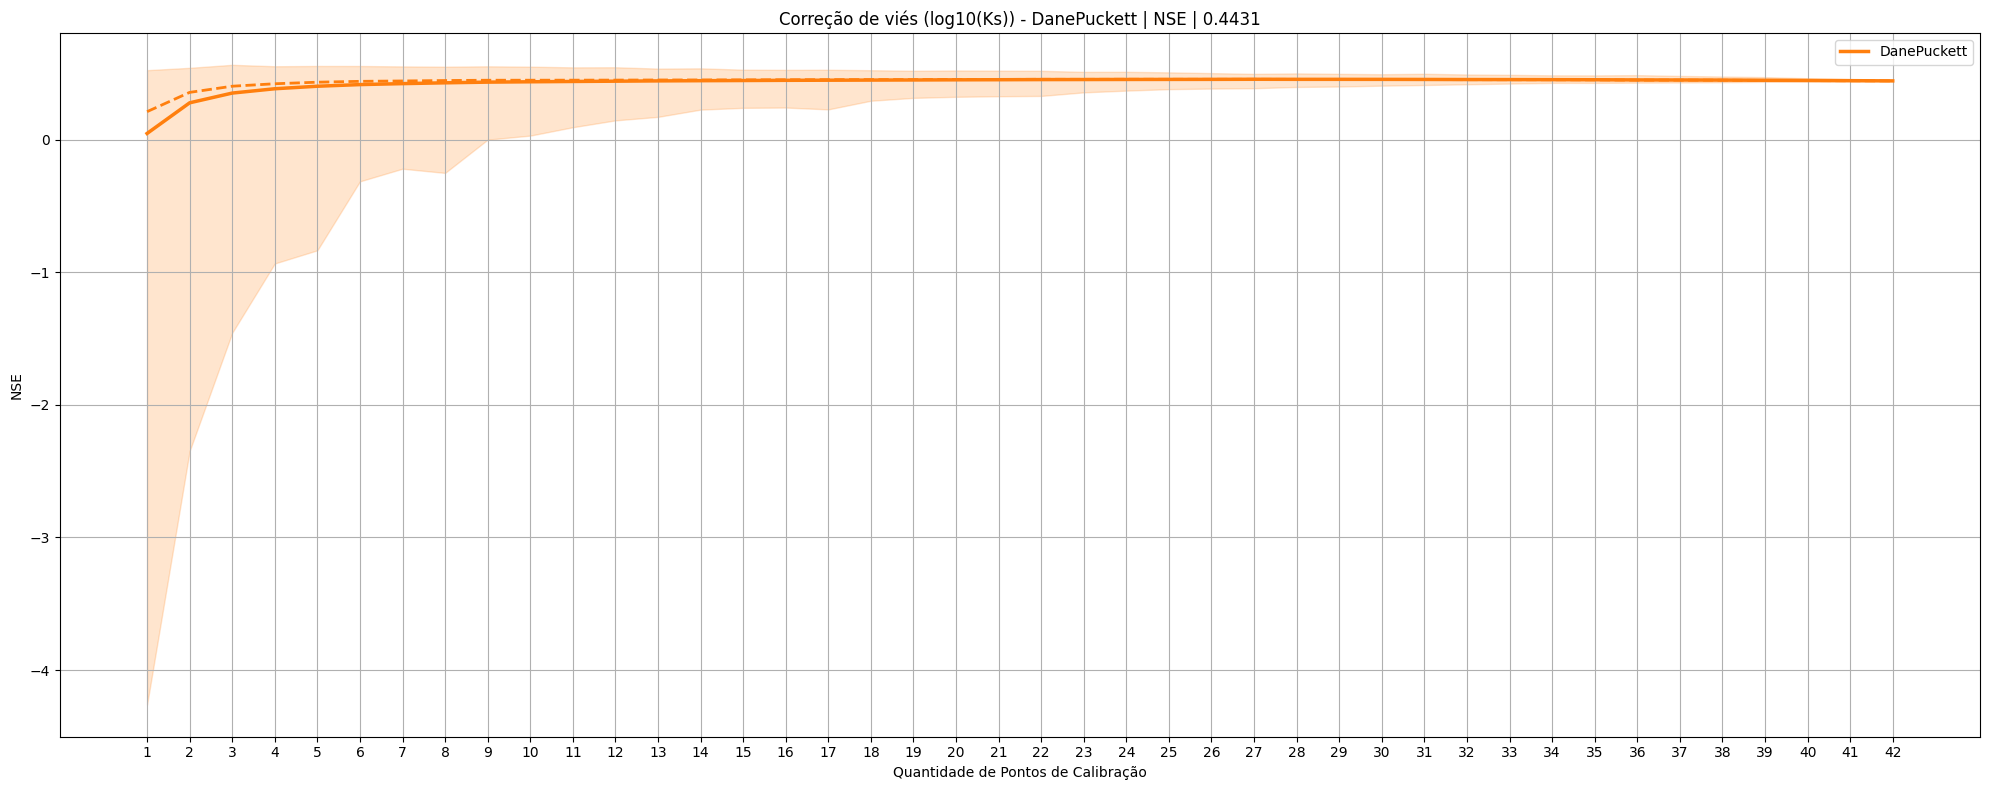

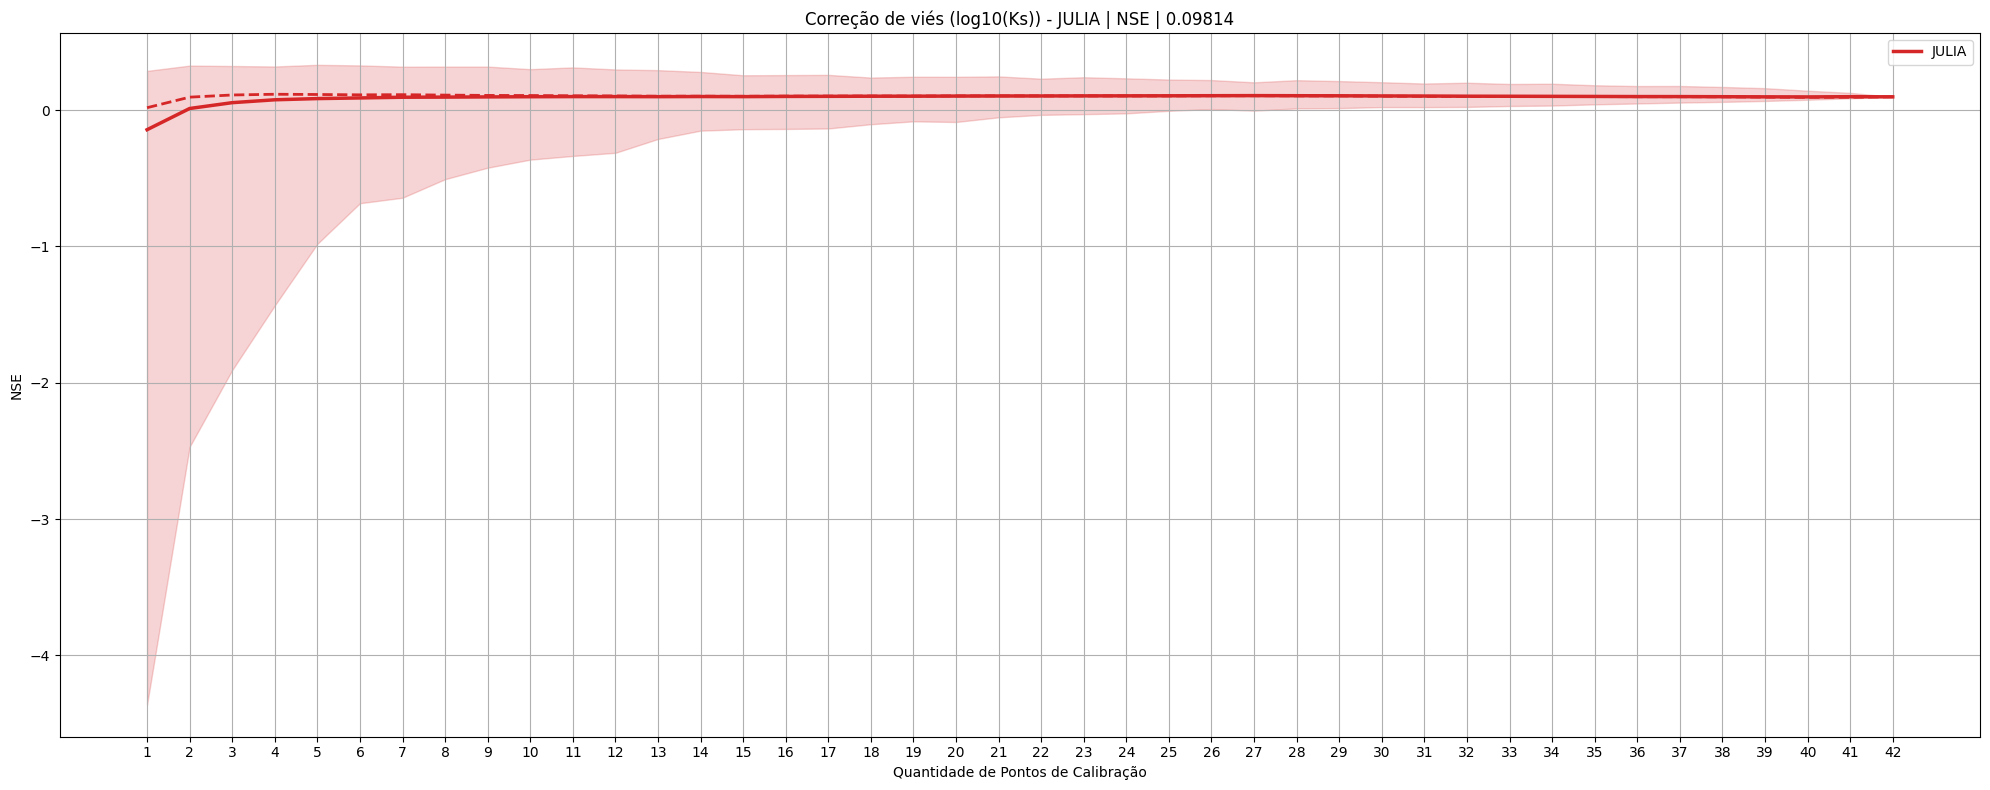

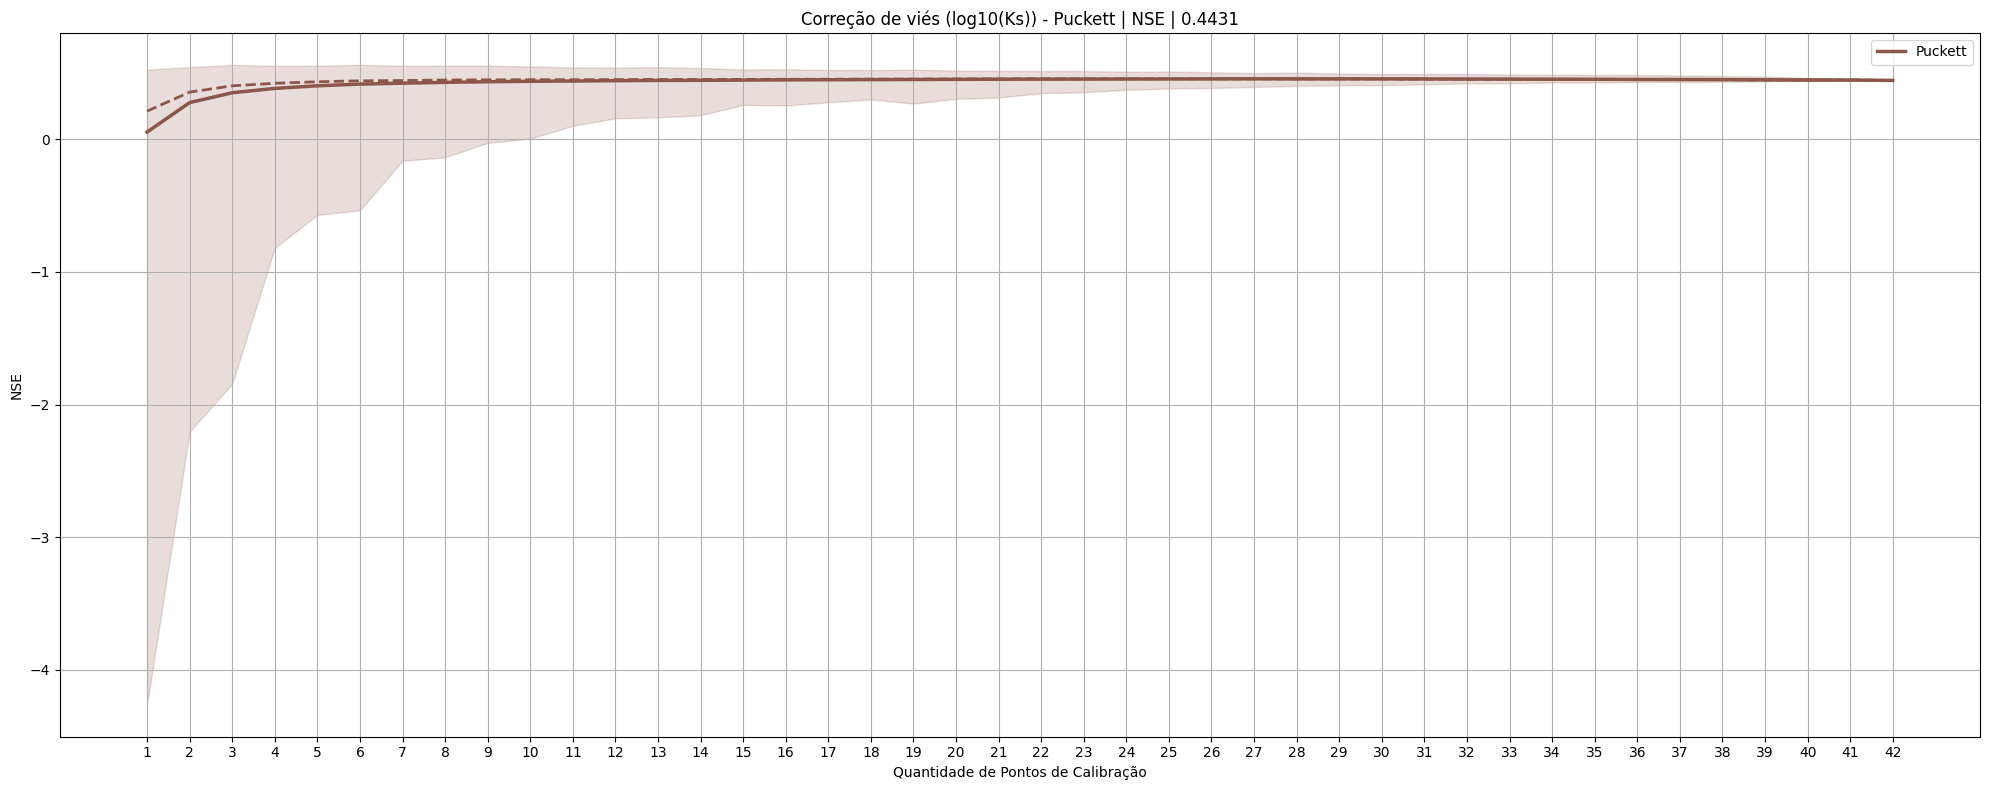

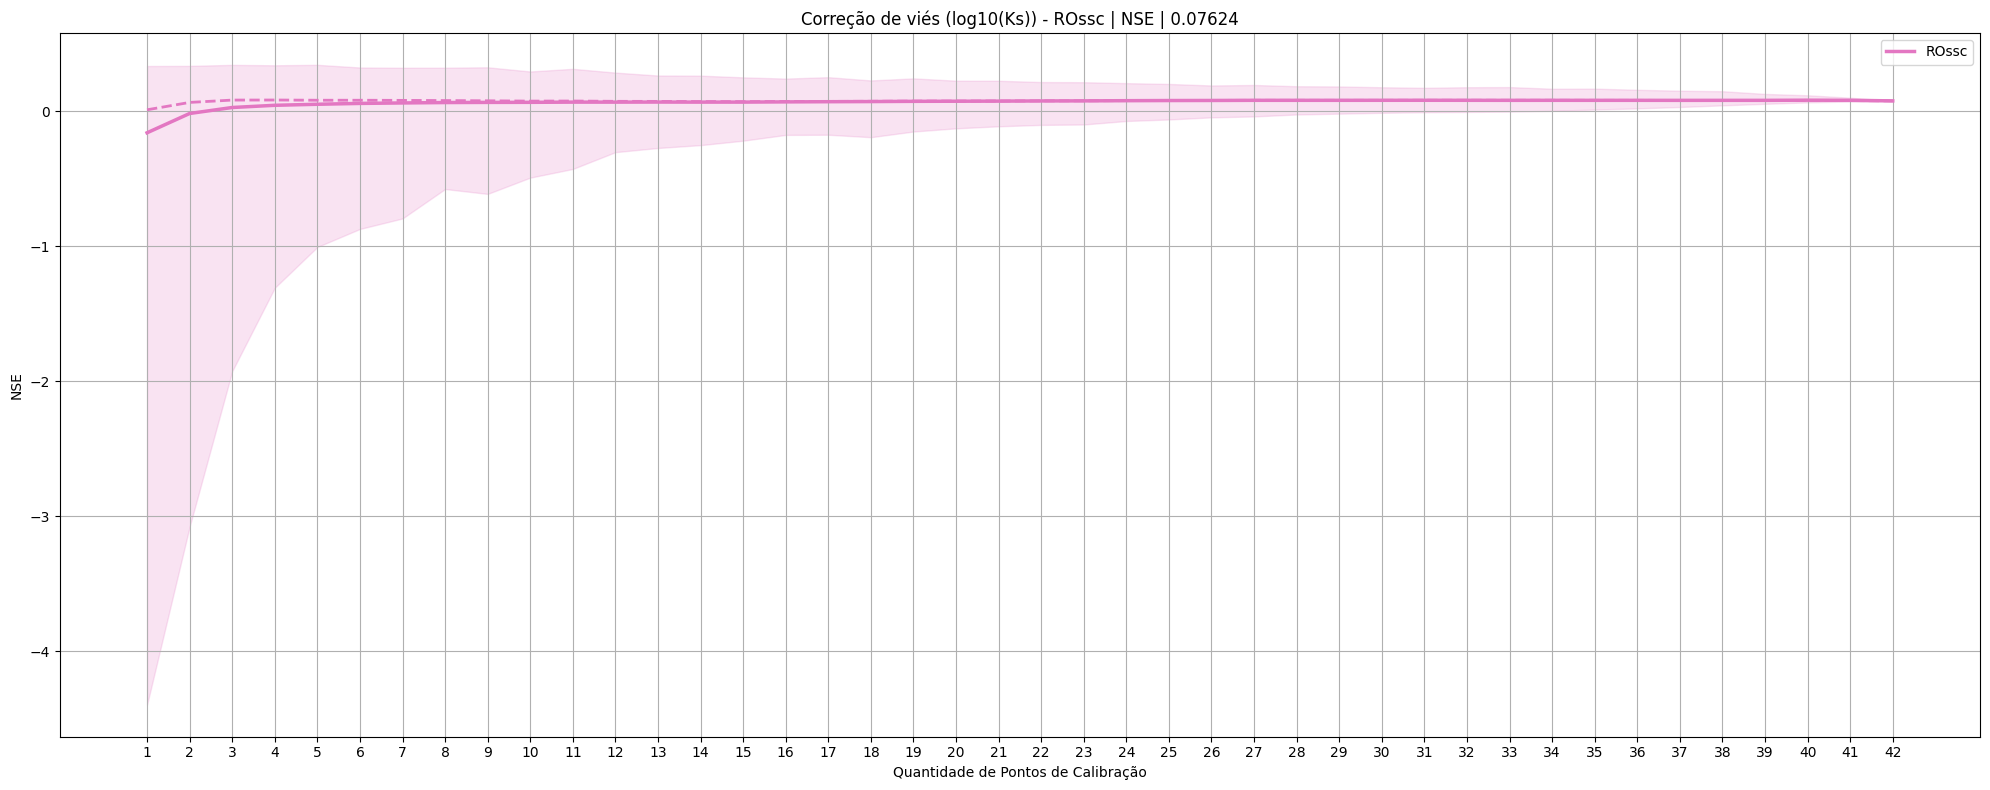

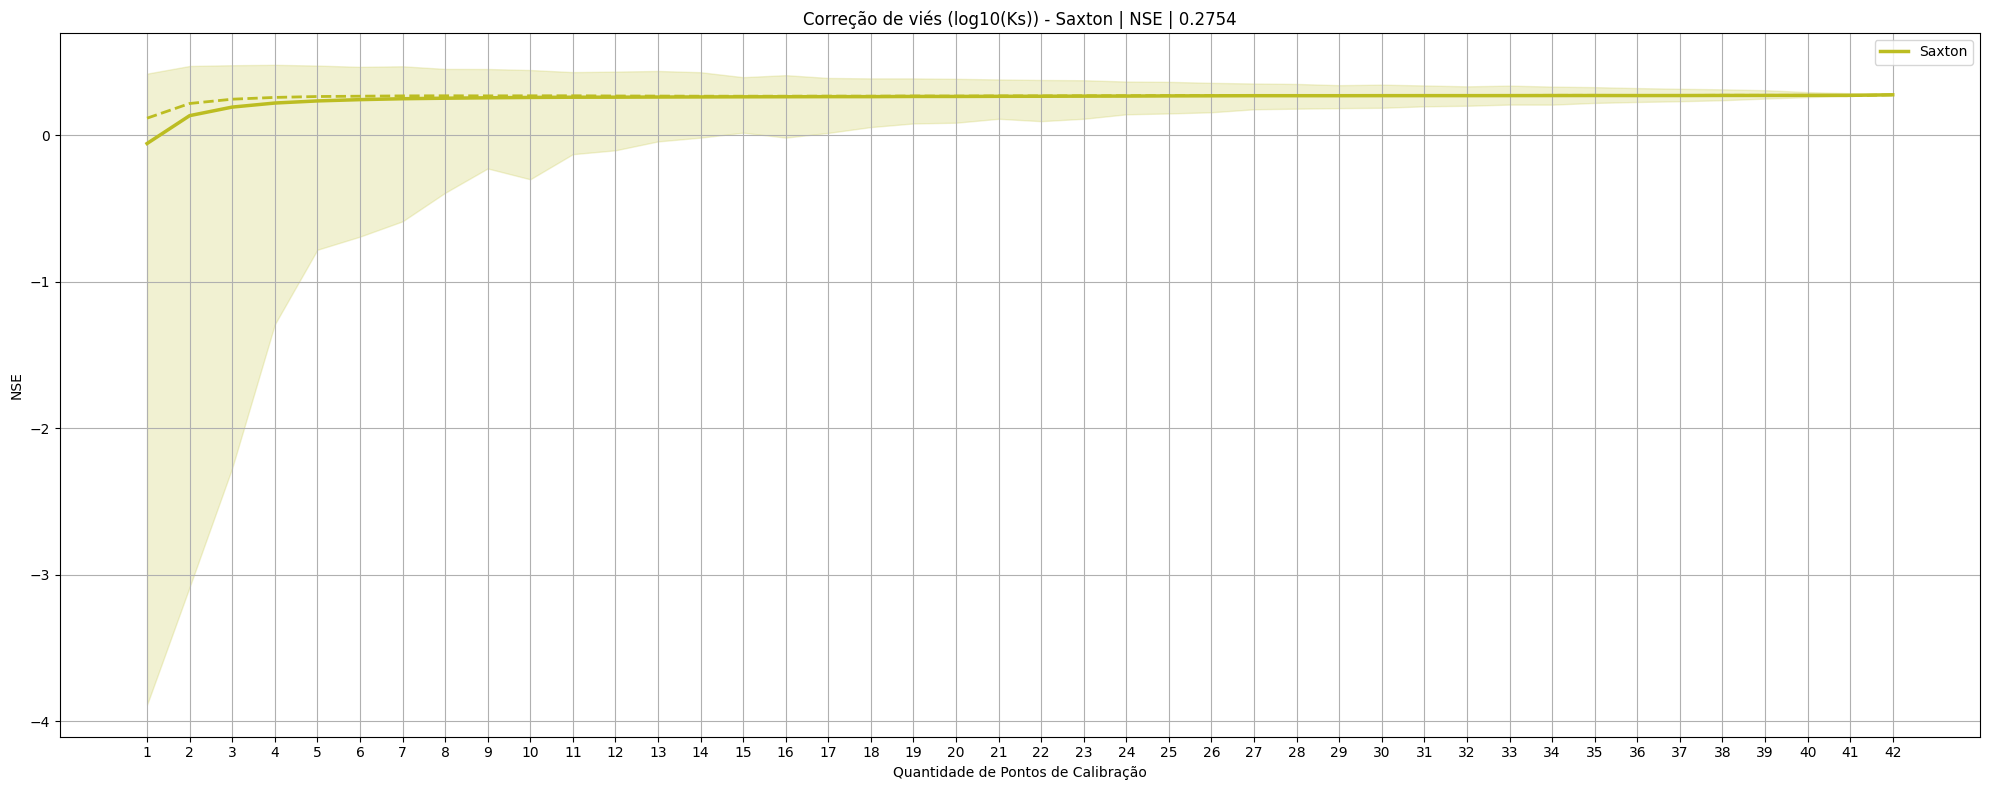

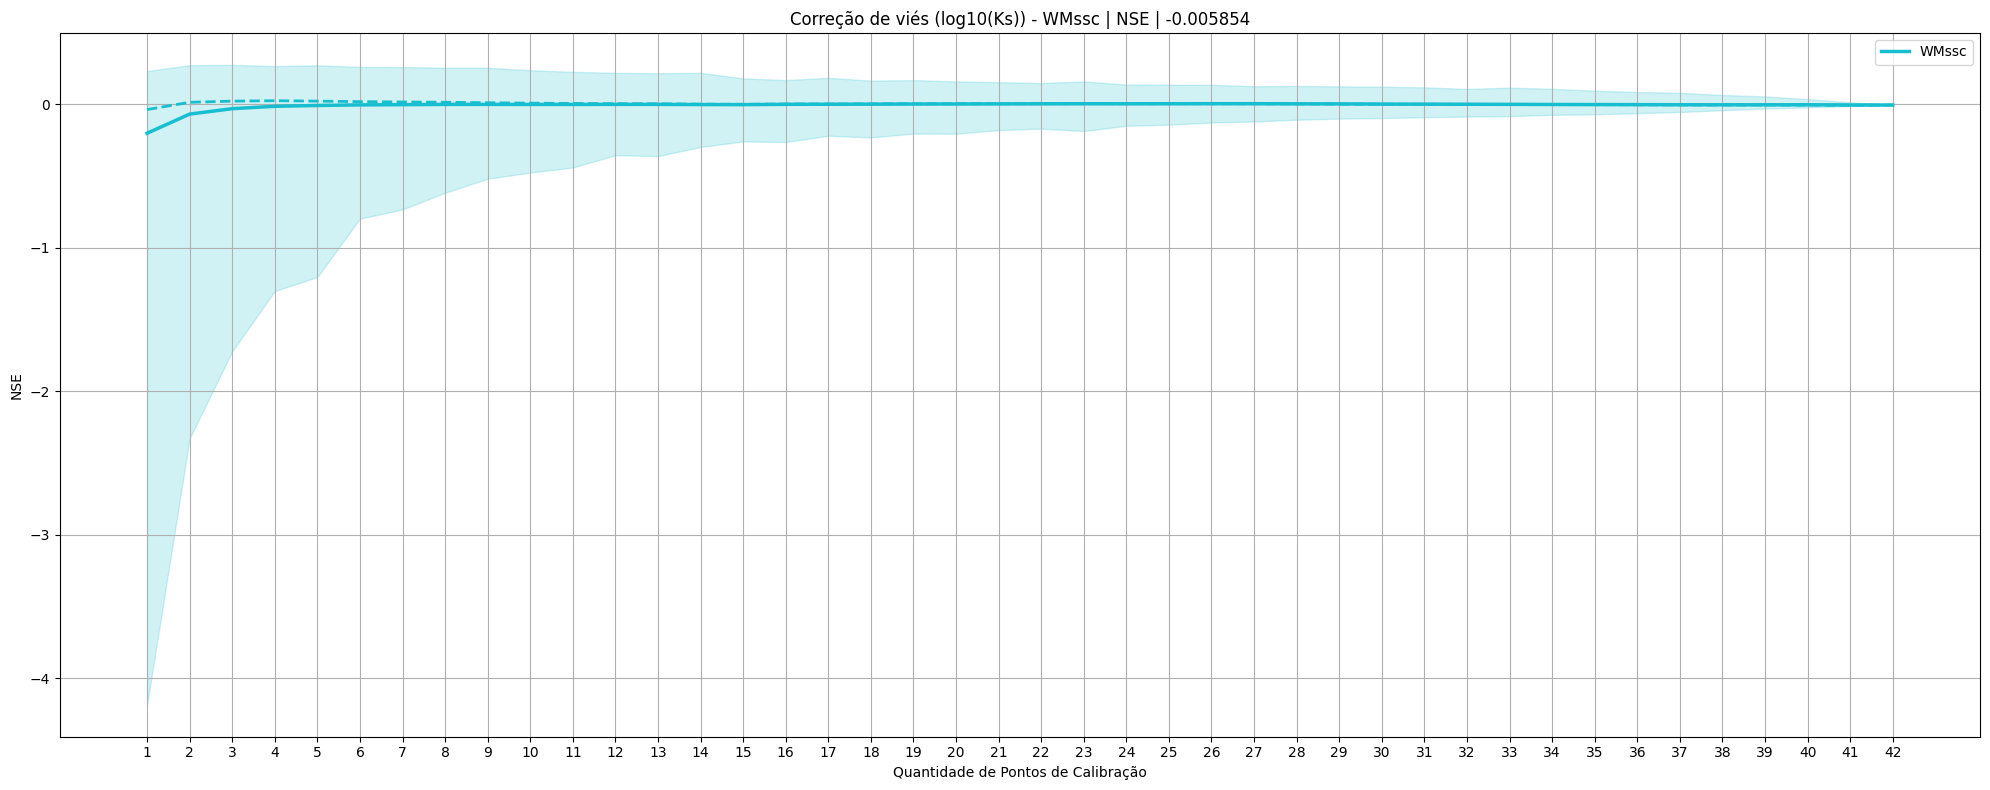

In [73]:
# NSE ou RMSE por número de pontos de calibração
params = ["RMSE", "NSE"]

x = np.arange(1, n_max+1)

path = f"simulacoes/2"
types = os.listdir(path)
colors = plt.cm.tab10(np.linspace(0, 1, len(types)))

for param in params:

    for color, sim_type in zip(colors, types):
        minimos  = []
        maximos  = []
        medios   = []
        medianos = []

        for i in range(1, n_max+1):
            df = pd.read_excel(f"{path}/{sim_type}/CV_{i}.xlsx", nrows=10)

            minimos.append(df[f"{param}_MIN"].values[0])
            maximos.append(df[f"{param}_MAX"].values[0])
            medios.append(df[f"{param}_MEAN"].values[0])
            medianos.append(df[f"{param}_MEDIAN"].values[0])

        plt.figure(figsize=(20, 8))

        # Área do mínimo ao máximo
        plt.fill_between(
            x, minimos, maximos,
            color=color,
            alpha=0.2,
        )

        # Linha média
        plt.plot(
            x, medios,
            color=color,
            linestyle="-",
            linewidth=2.5,
            label=sim_type
        )

        # Linha mediana
        plt.plot(
            x, medianos,
            color=color,
            linestyle="--",
            linewidth=2,
        )

        # Estética
        plt.xticks(np.arange(1, n_max+1))
        plt.xlabel("Quantidade de Pontos de Calibração")
        plt.ylabel(param)
        plt.title(f"Correção de viés (log10(Ks)) - {sim_type} | {param} | {medios[-1]:.4g}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Salvar
        plt.savefig(f"graficos/CV_NPontos_{sim_type}_{param}.png", dpi=450)
        plt.show()